# 掃Gate量IV 

In [1]:
import numpy as np
import pandas as pd
import pyvisa as visa
import matplotlib.pyplot as plt
import my_SR830
import os, time, threading, datetime, pymeasure,tqdm

from tqdm import trange,tqdm
from time import sleep
from datetime import date
from IPython import display
from pymeasure.adapters import VISAAdapter
from pathlib import Path

import qcodes as qc
import qcodes.instrument_drivers.QDevil.QDevil_QDAC as QDac
from qcodes.instrument_drivers.QDevil.QDevil_QDAC import Mode

print(datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
visa.ResourceManager().list_resources()

C:\Users\USER\Anaconda3\lib\site-packages\visa.py:23: FutureWarning: The visa module provided by PyVISA is being deprecated. You can replace `import visa` by `import pyvisa as visa` to achieve the same effect.

The reason for the deprecation is the possible conflict with the visa package provided by the https://github.com/visa-sdk/visa-python which can result in hard to debug situations.
  FutureWarning,


2021-04-20 09:46:51


('ASRL1::INSTR',
 'ASRL2::INSTR',
 'ASRL3::INSTR',
 'ASRL10::INSTR',
 'GPIB0::8::INSTR')

## 讀取830和QDac

In [2]:
SR830_GPIB_Addr = 8  ##請檢察GPIB號碼
srs_source = my_SR830.MY_SR830(SR830_GPIB_Addr)

qdac = QDac.QDac(name='qdac', address='ASRL3::INSTR', update_currents=False)
print('\nQDAC succesfully connected ! :)\n')
print("Number of channels: ",qdac.num_chans)


QDAC succesfully connected ! :)

Number of channels:  24


In [3]:
# This will query voltages of all channels of a 24 channel QDAC 
# Note that index 0 refer to channel 01, 1 refer to channel 02 and so on 
def show_now_all_voltage():
    np.set_printoptions(linewidth=1000)  ##for pretty printing
    print('Channel Voltage : ')
    feed = np.around(np.reshape(np.array(qdac.channels[0:24].v()),(3,8)),decimals=3)
    print(feed)
    return feed
# show_now_all_voltage()
# qdac.print_overview(update_currents=False)

##For more information see "QCodes example with QDevil_QDAC" file

def whilegoto(m_gate,volt):
    m_gate.v.set(volt)
    while abs(volt-m_gate.v.get())>1e-4: 
        display.clear_output(wait=True)
        print("Ramping %s voltage to %.6f (V) ...\ncurrent voltage is %.6f (V)"%(m_gate,volt,m_gate.v.get()))
        m_gate.v.set(volt)
        time.sleep(2)
    display.clear_output(wait=True)
    print("Done!")
    print("%s is now at %.6f Volts"%(m_gate,m_gate.v.get()))
    return m_gate.v.get()

def reshape_for_origin(m_data,m_data_points):
    A,B = np.split(m_data,[m_data_points])
    C,D = np.split(m_data,[m_data_points-1])
    return np.hstack((A,D))

## QDAC 設定 

In [4]:
QDAC_Channels = {
        "EG3"  : qdac.ch10,
        "EG4"  : qdac.ch14,
        "AG1"  : qdac.ch12,
        "BG3"  : qdac.ch03,
        "BG4"  : qdac.ch05,
       }

In [5]:
EG3  = qdac.ch10
EG4  = qdac.ch14
AG1  = qdac.ch12
BG3  = qdac.ch03
BG4  = qdac.ch05

In [6]:
# # # # gate.slope('Inf')  ## Careful with this one.
# gate.v.set(0.0)
# gate.mode(Mode.vlow_ilow)  ## 看要檢查什麼模式. !!!!! pls change mode at 0V !!!!!

EG3.mode(Mode.vhigh_ilow)
EG4.mode(Mode.vhigh_ilow)
AG1.mode(Mode.vhigh_ilow)
BG3.mode(Mode.vhigh_ilow)
BG4.mode(Mode.vhigh_ilow)

# For smooth voltage changes the maximal voltage change (in V/s) may be set for each channel
m = 0.01  #### 設定走多快
EG3.slope(m)
EG4.slope(m)
AG1.slope(m)
BG3.slope(m)
BG4.slope(m)

qdac.print_slopes()

Channel 3, slope: 0.01 (V/s)
Channel 5, slope: 0.01 (V/s)
Channel 10, slope: 0.01 (V/s)
Channel 12, slope: 0.01 (V/s)
Channel 14, slope: 0.01 (V/s)


## 830相關設定

In [7]:
SD_voltage_apply = 1

srs_goto_step = 0.05
srs_goto_delay_time=0.5
srs_source.input_config = 'A'
srs_source.input_grounding = 'Float'
srs_source.filter_slope = 24
srs_source.frequency = 227.11 # change the lock-in frequency
srs_source.time_constant = 0.1 # change the lock-in time constant
srs_source.sensitivity = 5e-5 # change the lock-in sensitivity
srs_source.channel1 = 'X'
srs_source.channel2 = 'Y'

srs_source.GOTO(SD_voltage_apply, srs_goto_step, srs_goto_delay_time) #給檢查Sensitivity
# srs_source.GOTO(0.004, srs_goto_step, srs_goto_delay_time) #歸零
# Lock-in 放大率(到2000需要乘上倍數)
# senstivity 2mv = 5000倍
# 10V / senstivity

## 量測相關設定

In [8]:
# gate_voltage_apply_1,n = [],'no input'

# min_V = 0.01##2    #initial voltage
# max_V = 0  #final voltage
# data_points = 11##201 #resolution for one sweep (min_V to max_V)

# forth = np.linspace(min_V, max_V,data_points)
# back = np.flip(forth,0)

# gate_voltage_apply_1 = forth
# gate_voltage_apply_1 = np.append(gate_voltage_apply_1[:-1],back)

# gate_voltage_apply_2 = min_V ## for all the other gates.

# print("\n掃過的電壓值如下")
# np.set_printoptions(linewidth=101)
# print(gate_voltage_apply_1)
# print('A total of %i elements'%gate_voltage_apply_1.size)

# measure_wait_time = 1  #電壓到時等一段時間穩定後再量測
# delay_time = 0.1    #每次調變所等待的時間

# N_ave = 2##6 #在一個電壓職重複量測幾次
# ave_wait = 0.5##1 #Lock-in 要等0.5秒才能再量
# fontsize = 8
# drawing_resolution = 10

# #分壓比例(Source Drain SR830)
# divider_ratio= 1e-5
# #放大器比例(Source Drain SR830)
# Amplifier_gain= 1e5

## 初始化所有閘級(全部都先到min_V)

In [12]:
gate_voltage_apply_2 = 0.7 ##, for all the other gates.
EG3.v.set(gate_voltage_apply_2)
EG4.v.set(gate_voltage_apply_2)
AG1.v.set(gate_voltage_apply_2)
BG3.v.set(gate_voltage_apply_2)
BG4.v.set(gate_voltage_apply_2)

In [14]:
for i in range(10):
    display.clear_output(wait=True)
    show_now_all_voltage()
    time.sleep(0.5)

Channel Voltage : 
[[-0.  -0.   0.7 -0.   0.7  0.  -0.   0. ]
 [-0.   0.7  0.   0.7  0.   0.7  0.   0. ]
 [ 0.  -0.   0.   0.  -0.  -0.   0.   0. ]]


## 路徑設定

In [ ]:
# repeat = 0
# ## ! ! ! ! ! ! ! ! ! ! ##
# pin_name = 'AG1'  ############################## 要輸入要量測的閘級
# ## ! ! ! ! ! ! ! ! ! ! ##
# folder_path = "C:/Users/USER/Sean/2021-04-16 QD pinchoff/" ##儲存的地方
# file_name = '%s_pinch_off_backandforth_others_at_%sV_repeat%s_at_%s'\
#     %(pin_name, gate_voltage_apply_2, repeat, date.today())##儲存的檔名

# print('檔名會叫做 >> %s'%file_name)

# overwrite = 'Y'
# if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
#     overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
# if overwrite == 'Y'or 'y':
#     file_name = file_name
# else:
#     file_name = '##'
#     print("please create a new file")
#     raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')

## 選擇要調控閘極

In [ ]:
# gate = QDAC_Channels[pin_name]   ##選擇要調控的輸出端子
# print("Controling ...")
# print(gate)
# gate.v.get()

# gate.mode(Mode.vhigh_ilow)
# print("\nGate mode :")
# print(gate.mode.cache().get_label())

# gate.slope(m)

In [ ]:
# whilegoto(gate,gate_voltage_apply_1[0]-0.01)
# time.sleep(1)
# print('Voltage before measurement was ...')
# show_now_all_voltage()

## 開始量測

In [ ]:
# current_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
# conductance_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
# current_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
# voltage_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))

# plt.figure(figsize=(3,3), dpi=200)  ##create empty graph
# plt.xlim([min_V,max_V])
    
# start = time.time()
# print("Apply Gate voltage...")
# for index_V, voltage in enumerate(tqdm(gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄
    
#     gate.v.set(voltage)
# #     time.sleep(0.5)
# #     now_v = gate.v.get()
# #     if abs(voltage-now_v)>1e-4:
# #         gate.v.set(voltage)
# #         time.sleep(1)
#     time.sleep(measure_wait_time)  ## wait a while before measurement
    
#     Sum_of_current, Sum_of_conductance, Sum_of_current_qdac,  Sum_of_voltage_qdac = 0, 0, 0, 0
    
#     ###量測################################################################
# #         print("measuring at %.6f ..."%qdac.ch01.v.get()) ## For cheking measuring output
#     for n in range(N_ave):

#         current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
#         conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
#         current_qdac_measure_xx[index_V,n] = gate.i()
#         voltage_qdac_measure_xx[index_V,n] = gate.v.get()

#         Sum_of_current += current_measure_xx[index_V,n]
#         Sum_of_conductance += conductance_measure_xx[index_V,n]
#         Sum_of_current_qdac += current_qdac_measure_xx[index_V,n]
#         Sum_of_voltage_qdac += voltage_qdac_measure_xx[index_V,n]

#         time.sleep(ave_wait) ## Lockin delay at least 0.5s

#     current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
#     conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值
#     current_qdac_measure_xx[index_V,N_ave] = Sum_of_current_qdac/float(N_ave)
#     voltage_qdac_measure_xx[index_V,N_ave] = Sum_of_voltage_qdac/float(N_ave)
        
#     ####畫圖################################################################
#     if (index_V%drawing_resolution==0):
#         display.clear_output(wait=True)

#         plt.subplot(4,1, 1)
#         plt.plot(gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
# #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
#         plt.xlabel("$V$ (V)")
#         plt.xticks(fontsize=fontsize)
#         plt.ylabel("$I$ (A)")
#         plt.yticks(fontsize=fontsize)

#         plt.subplot(4,1, 2)
#         plt.plot(gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
# #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
#         plt.xlabel("$V$ (V)")
#         plt.xticks(fontsize=fontsize)
#         plt.ylabel("$G$ (S)")
#         plt.yticks(fontsize=fontsize)
#         display.display(plt.gcf())
# #             print("Current temperature is %.4f K."%triton.GET_CURRENT_TEMPERATURE(control_channel))
# time.sleep(0.01)
# print("Measurement ends.")

# display.clear_output(wait=True)

# plt.subplot(4,1, 1)
# plt.plot(gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
# #plt.ylim([voltage_measure.min(),voltage_measure.max()])
# plt.xlabel("$V$ (V)")
# plt.xticks(fontsize=fontsize)
# plt.ylabel("$I$ (A)")
# plt.yticks(fontsize=fontsize)

# plt.subplot(4,1, 2)
# plt.plot(gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
# #plt.ylim([voltage_measure.min(),voltage_measure.max()])
# plt.xlabel("$V$ (V)")
# plt.xticks(fontsize=fontsize)
# plt.ylabel("$G$ (S)")
# plt.yticks(fontsize=fontsize)
# # plt.savefig('%s/Rxx.png'%folder_path[index_current],bbox_inches='tight', dpi=200, pad_inches=0.05) ##存圖片
# display.display(plt.gcf())

# stop = time.time()
# T=(stop-start)/60

# print("Measurement ends.")
# print('這次量測花費了 %f 分鐘'%T)
# print("DONE!!!")

In [ ]:
# voltage_log = np.hstack((gate_voltage_apply_1.reshape(-1,1), voltage_qdac_measure_xx[:, -1].reshape(-1,1),
#                          gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1),
#                          (gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))/gate_voltage_apply_1.reshape(-1,1)*100))

# raw_data = np.hstack((voltage_qdac_measure_xx, current_measure_xx, conductance_measure_xx,
#                       current_qdac_measure_xx,gate_voltage_apply_1.reshape(-1,1)))

# data = np.hstack((voltage_qdac_measure_xx[:,[-1]], current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]], 
#                   current_qdac_measure_xx[:,[-1]], gate_voltage_apply_1.reshape(-1,1)))

# data = reshape_for_origin(data, data_points)

# np.savetxt("%svoltage_log%s.txt" %(folder_path,file_name),voltage_log,comments='', fmt="%.8e", \
#            header='v_set\tv_actual\terror\terror_percentage\
#            \n(V)\t(V)\t(V)\t(%)')

# np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data,comments='', fmt="%.8e", \
#            header='V\tI*%d\tI_avg\tG*%d\tG_avg\tV_set\
#            \n(V)\t(A)\t(A)\t(S)\t(s)\t(V)'%(N_ave,N_ave))

# np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
#            header='Vag\tId_avg_of_%s\tG_avg_of_%s\tQDACcurrent\tV_set \
#            \n(V)\t(A)\t(S)\t(A)\V_set(V)\
#            \nfrom%sVto%sV\tresolution_%.4f(V)\t%s\tleakage_current\tset_V\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\t%spoints\tmeasure_wait_time_%s\tslope_%s'\
#            %(N_ave,N_ave,\
#                          \
#              min_V,max_V,(max_V-min_V)/(data_points-1),pin_name,min_V,min_V,min_V,min_V,min_V,data_points,measure_wait_time,m))


# 如有需要檢查電壓輸出可使用

In [ ]:
# pd.set_option('display.max_rows', None)
# pd.DataFrame(voltage_log,columns=['v_set', 'v_actual', 'error','error_rate (%)'])

In [ ]:
# np.set_printoptions(precision=3)
# arr = (gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))\
# /gate_voltage_apply_1.reshape(-1,1)*100 
# #### 調 decimal 當作判斷標準 可以知道有幾組電壓誤差超過此標準
# pd.DataFrame(np.around(arr,decimals=3),columns=['error_rate (%)'])  ## Ctrl+F 0.000 for quick find

# 包一包

In [15]:
def pinch(gate_name, repeat=0):

    gate_voltage_apply_1,n = [],'no input'

    min_V = 0.7    #initial voltage
    max_V = -1.3   #final voltage
    data_points = 201 #resolution for one sweep (min_V to max_V)

    forth = np.linspace(min_V, max_V,data_points)
    back = np.flip(forth,0)

    gate_voltage_apply_1 = forth
    gate_voltage_apply_1 = np.append(gate_voltage_apply_1[:-1],back)
    gate_voltage_apply_2 = min_V ## for all the other gates.
    measure_wait_time = 1  #電壓到時等一段時間穩定後再量測

    N_ave = 6 #在一個電壓職重複量測幾次
    ave_wait = 1 #Lock-in 要等0.5秒才能再量
    fontsize = 8
    drawing_resolution = 10

    divider_ratio= 1e-5 #分壓比例(Source Drain SR830)
    Amplifier_gain= 1e5 #放大器比例(Source Drain SR830)

    ###################################################################################################################
    pin_name = gate_name  
    folder_path = "C:/Users/USER/Sean/2021-04-16 QD pinchoff/" ##儲存的地方
    file_name = '%s_pinch_off_backandforth_others_at_%sV_repeat%s_at_%s'\
        %(pin_name, gate_voltage_apply_2, repeat, date.today())##儲存的檔名

    print('檔名會叫做 >> %s'%file_name)

    overwrite = 'Y'
    if os.path.isfile('%s%s.txt'%(folder_path,file_name))==True:
        overwrite = input('Do you want to overwtite the existing file? >>> Y/N  ')
    if overwrite == 'Y'or 'y':
        file_name = file_name
    else:
        file_name = '##'
        print("please create a new file")
        raise RuntimeError('!!!!  File exsit, please name a new file  !!!!')

    ###################################################################################################################
    gate = QDAC_Channels[pin_name]   ##選擇要調控的輸出端子
    gate.mode(Mode.vhigh_ilow)
    whilegoto(gate,min_V-0.01)
    ###################################################################################################################
    current_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1)) #製造0矩陣以放入量測數據
    conductance_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    current_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))
    voltage_qdac_measure_xx = np.zeros((len(gate_voltage_apply_1), N_ave+1))

    plt.figure(figsize=(3,3), dpi=200)  ##create empty graph
    plt.xlim([min_V,max_V])
    V_before = show_now_all_voltage()
    start = time.time()
    print("Apply Gate voltage...")
    for index_V, voltage in enumerate(tqdm(gate_voltage_apply_1)): #####開始掃GATE(P1)並量測記錄

        gate.v.set(voltage)
        time.sleep(0.5)
        while abs(voltage-gate.v.get())>1e-4: 
            gate.v.set(voltage)
            time.sleep(1)
        time.sleep(measure_wait_time)  ## wait a while before measurement

        Sum_of_current, Sum_of_conductance, Sum_of_current_qdac,  Sum_of_voltage_qdac = 0, 0, 0, 0

        ###量測################################################################
        for n in range(N_ave):

            current_measure_xx[index_V,n] = srs_source.x/Amplifier_gain   ##讀取Lock_in的值  絕對值:srs_source.magnitude
            conductance_measure_xx[index_V,n] = srs_source.x/Amplifier_gain/(SD_voltage_apply*divider_ratio)
            current_qdac_measure_xx[index_V,n] = gate.i()
            voltage_qdac_measure_xx[index_V,n] = gate.v.get()
#             print(show_now_all_voltage())
            Sum_of_current += current_measure_xx[index_V,n]
            Sum_of_conductance += conductance_measure_xx[index_V,n]
            Sum_of_current_qdac += current_qdac_measure_xx[index_V,n]
            Sum_of_voltage_qdac += voltage_qdac_measure_xx[index_V,n]

            time.sleep(ave_wait) ## Lockin delay at least 0.5s

        current_measure_xx[index_V,N_ave] = Sum_of_current/float(N_ave) #加上平均數值
        conductance_measure_xx[index_V,N_ave] = Sum_of_conductance/float(N_ave) #加上平均數值
        current_qdac_measure_xx[index_V,N_ave] = Sum_of_current_qdac/float(N_ave)
        voltage_qdac_measure_xx[index_V,N_ave] = Sum_of_voltage_qdac/float(N_ave)

        ####畫圖################################################################
        if (index_V%drawing_resolution==0):
            display.clear_output(wait=True)

            plt.subplot(4,1, 1)
            plt.plot(gate_voltage_apply_1[:index_V+1] , current_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$I$ (A)")
            plt.yticks(fontsize=fontsize)

            plt.subplot(4,1, 2)
            plt.plot(gate_voltage_apply_1[:index_V+1] , conductance_measure_xx[:index_V+1,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #           plt.ylim([voltage_measure.min(),voltage_measure.max()])
            plt.xlabel("$V$ (V)")
            plt.xticks(fontsize=fontsize)
            plt.ylabel("$G$ (S)")
            plt.yticks(fontsize=fontsize)
            display.display(plt.gcf())
    #             print("Current temperature is %.4f K."%triton.GET_CURRENT_TEMPERATURE(control_channel))
    time.sleep(0.01)
    display.clear_output(wait=True)
    
    plt.subplot(4,1, 1)
    plt.plot(gate_voltage_apply_1 , current_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$I$ (A)")
    plt.yticks(fontsize=fontsize)

    plt.subplot(4,1, 2)
    plt.plot(gate_voltage_apply_1 , conductance_measure_xx[:,N_ave], c='r')#, label='$\\rho_{xy} pin 2-11$')
    #plt.ylim([voltage_measure.min(),voltage_measure.max()])
    plt.xlabel("$V$ (V)")
    plt.xticks(fontsize=fontsize)
    plt.ylabel("$G$ (S)")
    plt.yticks(fontsize=fontsize)
    # plt.savefig('%s/Rxx.png'%folder_path[index_current],bbox_inches='tight', dpi=200, pad_inches=0.05) ##存圖片
    display.display(plt.gcf())

    ###################################################################################################################
    voltage_log = np.hstack((gate_voltage_apply_1.reshape(-1,1), voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1),
                             (gate_voltage_apply_1.reshape(-1,1)-voltage_qdac_measure_xx[:, -1].reshape(-1,1))/gate_voltage_apply_1.reshape(-1,1)*100))

    raw_data = np.hstack((voltage_qdac_measure_xx, current_measure_xx, conductance_measure_xx,
                          current_qdac_measure_xx,gate_voltage_apply_1.reshape(-1,1)))

    data = np.hstack((voltage_qdac_measure_xx[:,[-1]], current_measure_xx[:,[-1]], conductance_measure_xx[:,[-1]], 
                      current_qdac_measure_xx[:,[-1]], gate_voltage_apply_1.reshape(-1,1)))

    data = reshape_for_origin(data, data_points)

    np.savetxt("%svoltage_log%s.txt" %(folder_path,file_name),voltage_log,comments='', fmt="%.8e", \
               header='v_set\tv_actual\terror\terror_percentage\
               \n(V)\t(V)\t(V)\t(%)')

    np.savetxt("%sraw_data%s.txt" %(folder_path,file_name),raw_data,comments='', fmt="%.8e", \
               header='V\tI*%d\tI_avg\tG*%d\tG_avg\tV_set\
               \n(V)\t(A)\t(A)\t(S)\t(s)\t(V)'%(N_ave,N_ave))

    np.savetxt('%s%s.txt'%(folder_path,file_name),data, fmt="%.8e",comments='',\
               header='Vag\tId_avg_of_%s\tG_avg_of_%s\tQDACcurrent\tV_set \
               \n(V)\t(A)\t(S)\t(A)\V_set(V)\
               \nfrom%sVto%sV\tresolution_%.4f(V)\t%s\tleakage_current\tset_V\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\tback_to_%s\t%spoints\tmeasure_wait_time_%s\tslope_%s'\
               %(N_ave,N_ave,\
                             \
                 min_V,max_V,(max_V-min_V)/(data_points-1),pin_name,min_V,min_V,min_V,min_V,min_V,data_points,measure_wait_time,m))


    ###################################################################################################################
    stop = time.time()
    T=(stop-start)/60
    V_after = show_now_all_voltage()
    display.clear_output(wait=True)
    print("Measurement ends.\n這次量測花費了 %f 分鐘\nDONE!!!\n"%T)
    print("Voltage before measurement : ")
    print(V_before)
    print("Voltage after measurement : ")
    print(V_after)
    show_now_all_voltage()

In [16]:
show_now_all_voltage()

Channel Voltage : 
[[-0.  -0.   0.7 -0.   0.7  0.  -0.   0. ]
 [-0.   0.7  0.   0.7  0.   0.7  0.   0. ]
 [ 0.  -0.   0.   0.  -0.  -0.   0.   0. ]]


array([[-0. , -0. ,  0.7, -0. ,  0.7,  0. , -0. ,  0. ],
       [-0. ,  0.7,  0. ,  0.7,  0. ,  0.7,  0. ,  0. ],
       [ 0. , -0. ,  0. ,  0. , -0. , -0. ,  0. ,  0. ]])

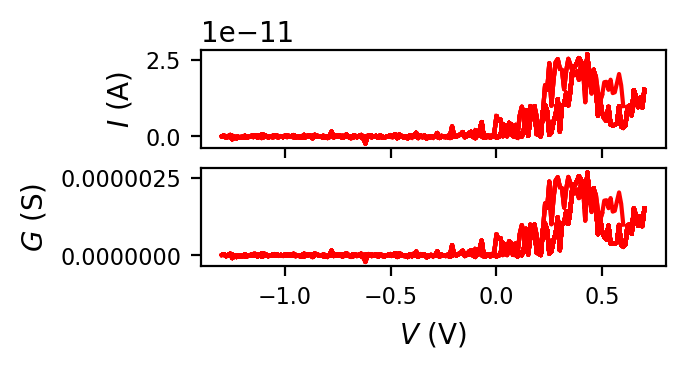

100%|█████████████████████████████████████████████████████████████████████████████▌| 399/401 [1:15:28<00:22, 11.00s/it]

In [ ]:
pinch('AG1')

In [ ]:
pinch('BG3')

In [ ]:
pinch('BG4')

In [ ]:
pinch('EG3')

In [ ]:
pinch('EG4')

In [ ]:
pinch('AG1',1)

In [ ]:
pinch('BG3',1)

In [ ]:
pinch('BG4',1)

In [ ]:
pinch('EG3',1)

In [ ]:
pinch('EG4',1)

## 手動歸零

In [ ]:
set_v = 0.0 ## for all the other gates.

EG3.v.set(set_v)
EG4.v.set(set_v)
AG1.v.set(set_v)
BG3.v.set(set_v)
BG4.v.set(set_v)

In [ ]:
for i in range(5):
    display.clear_output(wait=True)
    show_now_all_voltage()
    time.sleep(0.5)